In [53]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
import json

# 📊RF
#### 💾 Carregamento e preparação da série temporal

In [54]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

# Função para criar a "design matrix" (matriz de features) a partir do DataFrame original. Esta matriz será usada como entrada para modelos de Machine Learning
def create_features(df):
    # Cria um novo DataFrame X com as features base: hora do dia e temperatura
    X = pd.DataFrame({
        "Hour": df["Hour"],               # Hora (0 a 23)
        "Temperature": df["Temperature"] # Temperatura associada ao registo
    })

    # Mapeia o período do dia ("Manhã", "Tarde", "Noite") para valores inteiros
    tod_map = {"Manhã":0, "Tarde":1, "Noite":2}
    X["TimeOfDay"] = df["TimeOfDay"].map(tod_map).fillna(0).astype(int)

    # Mapeia o dia da semana ("Segunda", ..., "Domingo") para valores inteiros de 0 a 6
    dofw_map = {
        "Segunda":0, "Terça":1, "Quarta":2, "Quinta":3,
        "Sexta":4, "Sábado":5, "Domingo":6
    }
    X["DayOfTheWeek"] = df["DayOfTheWeek"].map(dofw_map).fillna(0).astype(int)
    return X     # Retorna o DataFrame X com as features transformadas, pronto para treino/predição

#### ✂️ Split treino/teste

In [55]:
# Separa os dados em treino e teste com base na data

train_df = df_cp[df_cp["DateTime"] < "2023-09-30"] # Dados de treino: todos os registos anteriores a 30 de setembro de 2023

# Dados de teste: apenas os registos de 30 de setembro de 2023 (entre 00:00 e 23:59)
test_df  = df_cp[
    (df_cp["DateTime"] >= "2023-09-30") &
    (df_cp["DateTime"] <  "2023-10-01")
]

X_train = create_features(train_df) # Aplica a função de criação de features (design matrix) aos dados de treino
y_train = train_df["EnergyNormalized"].to_numpy() # Extrai o vetor de valores alvo (target) para treino — consumo energético normalizado
X_test  = create_features(test_df) # Aplica a mesma transformação de features aos dados de teste
y_test  = test_df["EnergyNormalized"].to_numpy() # Extrai o vetor de valores reais (target) para teste

In [56]:
# Escala (normaliza) as features numéricas para melhorar o desempenho de modelos de ML

cols_to_scale = ["Hour", "Temperature"] # 1) Define quais colunas devem ser escaladas (neste caso: hora do dia e temperatura)

# 2) Cria um objeto StandardScaler e ajusta-o com os dados de treino apenas. O StandardScaler transforma os dados para que tenham média 0 e desvio padrão 1
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])  # Nunca usar os dados de teste aqui!

# 3) Aplica a transformação às colunas selecionadas do treino
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

# Aplica a mesma transformação ao conjunto de teste (usando o scaler treinado no treino)
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#### 💾 Carregamento do modelo

In [59]:
# (Opcional) Carrega um modelo previamente treinado a partir do disco
# Neste caso, um pipeline de Machine Learning treinado com Random Forest
# O ficheiro foi guardado anteriormente com a biblioteca joblib
pipeline = load("../predicts/RF/modelo/RF_pipeline.joblib")

#### 🛠️ Treinar

In [58]:
# Cria um pipeline de Machine Learning com duas etapas:
pipeline = Pipeline([
    ("scaler", ColumnTransformer([
        ("hour_temp", StandardScaler(), ["Hour", "Temperature"]) # 1. Pré-processamento: normaliza as colunas "Hour" e "Temperature" com StandardScaler
    ], remainder="passthrough")), # As restantes colunas são mantidas como estão (remainder="passthrough")

    # 2. Modelo de regressão: Random Forest com 100 árvores
    ("rf", RandomForestRegressor(
        n_estimators=100,      # Número de árvores
        random_state=123,      # Semente para reprodutibilidade
        n_jobs=-1              # Usa todos os núcleos do CPU disponíveis
    ))
])

pipeline.fit(X_train, y_train) # Treina o pipeline com os dados de treino (X e y)
dump(pipeline, "../predicts/RF/modelo/RF_pipeline.joblib") # Guarda o pipeline treinado num ficheiro para reutilização futura

['../predicts/RF/modelo/RF_pipeline.joblib']

#### 📈 Previsão e avaliação

In [60]:
y_pred = pipeline.predict(X_test) # Usa o pipeline treinado para fazer previsões no conjunto de teste

# Calcula métricas de avaliação para comparar previsões com os valores reais
mae  = mean_absolute_error(y_test, y_pred)                # MAE: Erro absoluto médio
mse  = mean_squared_error(y_test, y_pred)                 # MSE: Erro quadrático médio
rmse = np.sqrt(mse)                                       # RMSE: Raiz do erro quadrático médio
mape = (np.abs((y_test - y_pred) / y_test) * 100).mean()  # MAPE: Erro percentual absoluto médio
r2 = r2_score(y_test, y_pred)                             # R²: Coeficiente de determinação

# Agrupa as métricas calculadas num dicionário
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²":    r2
}

# Exporta as métricas para um ficheiro JSON, para registo ou análise posterior
with open("../predicts/RF/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# Imprime as métricas no terminal com formatação
print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.5f}")

MAE:  0.00337
MSE:  0.00002
RMSE: 0.00438
MAPE: 7.55%
R²: 0.68452


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                      |
|----------------------------------------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00337 | O erro médio absoluto é bastante reduzido, indicando que, em média, a RF prevê o consumo com um desvio muito pequeno em relação aos valores reais. |
| **MSE** (Erro Quadrático Médio)              | 0.00002 | Um erro quadrático médio extremamente baixo, sugerindo que grandes erros são raros. O modelo apresenta alta precisão e estabilidade nas previsões. |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00438 | Com um RMSE inferior a 0.005, o modelo consegue manter os erros dentro de uma margem pequena em relação à variabilidade do consumo energético. |
| **MAPE** (Erro Percentual Absoluto Médio)    | 7.55%   | O erro percentual médio de cerca de 7,5\% mostra que a RF prevê com boa precisão, tendo melhor desempenho do que o ARIMA. |
| **R²**   | 0.68452  | O modelo explica cerca de 68% da variabilidade dos dados reais — desempenho sólido |

#### 🖼️ Visualização gráfica

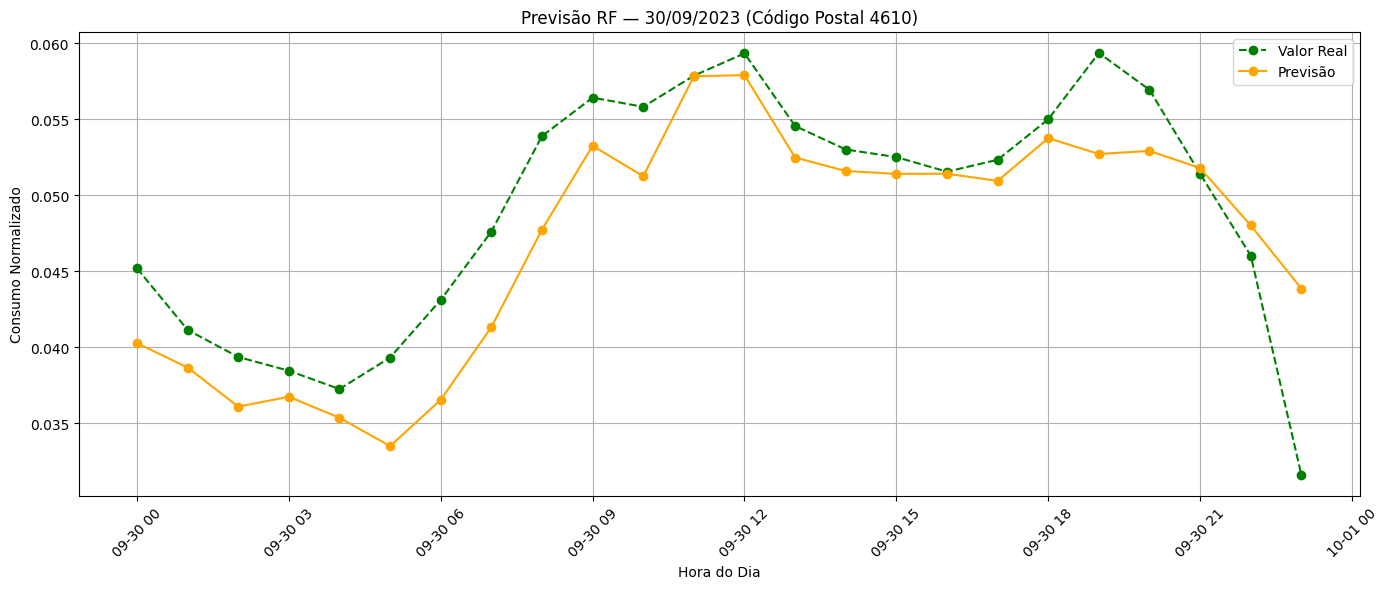

In [61]:
timestamps = test_df["DateTime"] # Extrai a coluna de timestamps (DateTime) do conjunto de teste. Estes serão usados como eixo X no gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas

plt.plot(timestamps, y_test, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo Random Forest com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor legibilidade
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão RF — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para identificar as linhas (real vs previsão)
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes
plt.savefig("../predicts/RF/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/RF'
plt.show() # Exibe o gráfico

# 📊LSTM
#### 💾 Carregamento e preparação da série temporal

In [62]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

static_feats = (df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates() .copy()) # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"] # Lista de variáveis conhecidas no tempo (known covariates). Estas são colunas que estarão disponíveis tanto no treino como no futuro (ex: hora, temperatura, dia da semana)

#### ✂️ Split treino/teste

In [63]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo LSTM


In [64]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/LSTM/modelo/"
predictor_lstm = TimeSeriesPredictor.load("../predicts/LSTM/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\LSTM\modelo


In [11]:
# --- 3) Treinar um LSTM usando o RNNModel (via DeepAR) ---

# Cria o preditor de séries temporais usando AutoGluon
predictor_lstm = TimeSeriesPredictor(
    target="EnergyNormalized",         # Coluna a ser prevista (variável dependente)
    prediction_length=24,             # Número de passos futuros a prever (24 horas)
    freq="h",                          # Frequência dos dados: horária
    known_covariates_names=known_covs, # Lista de variáveis conhecidas ao longo do tempo (ex: hora, temperatura)
    path="../predicts/LSTM/modelo"  # Caminho onde o modelo treinado será guardado
).fit(
    train_data,                        # Conjunto de treino (TimeSeriesDataFrame)
    tuning_data=test_data,            # Conjunto de validação (para ajustar hiperparâmetros)
    hyperparameters={
        "DeepAR": {                   # Modelo baseado em LSTM (DeepAR)
            "context_length": 48,    # Número de passos passados que o modelo observa (janelas de 48h)
            "hidden_size": 64,       # Tamanho do vetor de estado escondido nas camadas LSTM
            "num_layers": 2,         # Número de camadas LSTM empilhadas
            "dropout": 0.1,          # Dropout para regularização (evitar overfitting)
            "learning_rate": 1e-3,   # Taxa de aprendizagem do otimizador
            "epochs": 20,            # Número máximo de épocas de treino
            "target_scaler": "standard",  # Normalização da variável alvo (média 0, desvio padrão 1)
        }
    },
    presets="medium_quality",         # Conjunto de definições equilibradas entre qualidade e desempenho
    time_limit=3600                   # Tempo máximo de treino: 1 hora
)

predictor_lstm.save() # Guarda o modelo treinado no disco para reutilização futura

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\LSTM\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.60 GB / 15.93 GB (22.6%)
Disk Space Avail:   704.11 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'context_length': 48,
                                'dropout': 0.1,
                                'epochs': 20,
                                'hidden_size': 64,
                                'learning_rate': 0.001,
                                'num_layers': 2,
                                'target_scaler': 'standard'}},
 'known_covariates_nam

#### 🔮Preparação das covariáveis futuras para previsão

In [65]:
last_time = train_data.index.get_level_values("timestamp").max() # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [66]:
# Usa o modelo LSTM (DeepAR) para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_lstm.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[preds.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento
metrics = predictor_lstm.evaluate(test_data) # Avalia o desempenho do modelo com as métricas internas do AutoGluon

Model not specified in predict, will default to the model with the best validation score: DeepAR
Model not specified in predict, will default to the model with the best validation score: DeepAR


#### 📊 Cálculo de métricas

In [67]:
# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

# Verifica se ambos têm o mesmo tamanho (por segurança)
n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# --- Cálculo de erros individuais ---
abs_errs = np.abs(y_true - y_pred)              # Erros absolutos
sq_errs  = (y_true - y_pred) ** 2               # Erros quadráticos
pct_errs = np.abs((y_true - y_pred) / y_true) * 100  # Erros percentuais absolutos (%)

# --- Cálculo das métricas globais ---
MAE  = abs_errs.mean()             # Erro absoluto médio
MSE  = sq_errs.mean()              # Erro quadrático médio
RMSE = np.sqrt(MSE)                # Raiz do erro quadrático médio
MAPE = pct_errs.mean()             # Erro percentual absoluto médio (%)
r2   = r2_score(y_true, y_pred)    # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²":    r2
}

with open("../predicts/LSTM/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00210
MSE: 0.00001
RMSE: 0.00314
MAPE: 4.63803%
R²: 0.83771


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                |
|----------------------------------------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00239 | O LSTM apresenta um erro médio extremamente baixo, o que indica uma capacidade muito elevada de seguir o consumo real hora a hora.           |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O valor reduzido mostra que o modelo raramente comete grandes erros e tem previsões muito estáveis, sem picos de desvio elevados.            |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00336 | Representa um erro médio em torno de 0.0031, muito inferior ao observado na maioria dos modelos testados, sinalizando alta precisão global.  |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.21%   | O LSTM atinge o melhor resultado percentual até agora, errando em média 5.21\% em relação aos valores reais — excelente para aplicações reais. |
| **R²**   | 0.81448  | O modelo explica 81% da variabilidade dos dados reais — ótimo!                                                                               |

#### 🖼️ Visualização gráfica

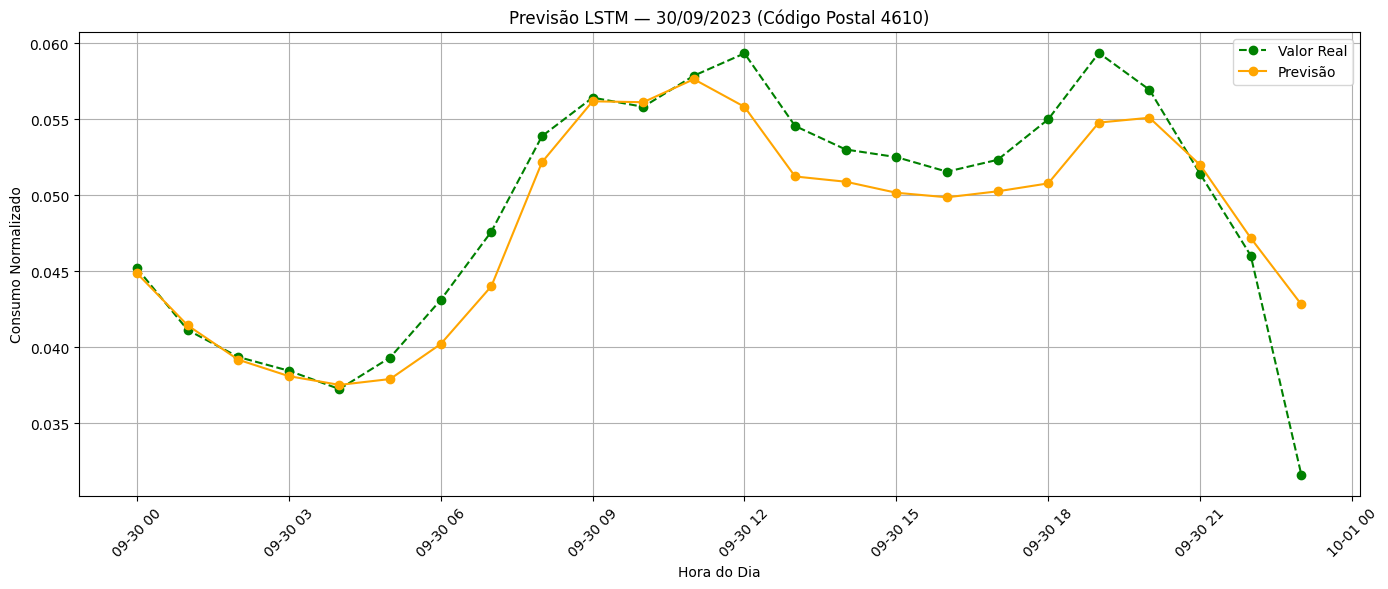

In [68]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão LSTM — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/LSTM/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/LSTM'
plt.show() # Exibe o gráfico

# 📊CNN
#### 💾 Carregamento e preparação da série temporal

In [69]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

static_feats = (df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()) # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"] # Lista de variáveis conhecidas no tempo (known covariates). Estas são colunas que estarão disponíveis tanto no treino como no futuro (ex: hora, temperatura, dia da semana)

#### ✂️ Split treino/teste

In [71]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo CNN

In [72]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/CNN/modelo/"
predictor_cnn = TimeSeriesPredictor.load("../predicts/CNN/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\CNN\modelo


In [19]:
# --- 3) Treinar um CNN ---

# Cria um preditor de séries temporais com base em CNN (WaveNet)
predictor_cnn = TimeSeriesPredictor(
    target="EnergyNormalized",         # Coluna alvo a ser prevista
    prediction_length=24,              # Previsão para as próximas 24 horas
    freq="h",                          # Frequência horária dos dados
    known_covariates_names=known_covs, # Covariáveis conhecidas (features temporais auxiliares)
    path="../predicts/CNN/modelo"  # Caminho onde o modelo treinado será guardado
).fit(
    train_data,                        # Dados de treino
    tuning_data=test_data,             # Dados de validação para ajustar o modelo
    hyperparameters={
        "WaveNet": {}                  # Utiliza a arquitetura WaveNet (CNN para séries temporais) com configurações padrão
    },
    presets="medium_quality",          # Usa um preset de qualidade média (equilíbrio entre desempenho e tempo)
    time_limit=600,                    # Tempo máximo de treino: 10 minutos
    skip_model_selection=True          # Evita ensemble/model selection, força uso exclusivo do WaveNet
)

predictor_cnn.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\CNN\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.59 GB / 15.93 GB (22.5%)
Disk Space Avail:   704.11 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'WaveNet': {}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNormalized',
 'time_limit': 600,
 'v

#### 🔮Preparação das covariáveis futuras para previsão

In [73]:
last_time = train_data.index.get_level_values("timestamp").max()  # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[df_cp["DateTime"].isin(future_times), ["ZipCode", "DateTime"] + known_covs].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [74]:
# Usa o modelo CNN para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_cnn.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[preds.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento
metrics = predictor_cnn.evaluate(test_data) # Avalia o desempenho do modelo com as métricas internas do AutoGluon

Model not specified in predict, will default to the model with the best validation score: WaveNet
Model not specified in predict, will default to the model with the best validation score: WaveNet


#### 📊 Cálculo de métricas

In [75]:
# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

# Verifica se ambos têm o mesmo tamanho (por segurança)
n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# --- Cálculo de erros individuais ---
abs_errs    = np.abs(y_true - y_pred) # Erros absolutos
sq_errs     = (y_true - y_pred) ** 2 # Erros quadráticos
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # Erros percentuais absolutos (%)

# --- Cálculo das métricas globais ---
MAE  = abs_errs.mean() # Erro absoluto médio
MSE  = sq_errs.mean() # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = pct_errs.mean() # Erro percentual absoluto médio (%)
r2 = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("../predicts/CNN/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00373
MSE: 0.00003
RMSE: 0.00516
MAPE: 8.07783%
R²: 0.56154


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                    |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00373 | O erro médio absoluto é baixo, indicando que as previsões da CNN estão geralmente muito próximas dos valores reais de consumo energético.                        |
| **MSE** (Erro Quadrático Médio)              | 0.00003 | O erro quadrático médio também é reduzido, o que mostra que grandes desvios entre previsão e realidade são pouco frequentes.                                     |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00516 | Com um RMSE inferior a 0.01, o modelo mantém os erros dentro de uma margem aceitável, demonstrando uma boa estabilidade nas previsões horárias.                  |
| **MAPE** (Erro Percentual Absoluto Médio)    | 8.08%   | O modelo apresenta um erro percentual médio de aproximadamente 8\%, o que é considerado bom para séries temporais energéticas, mas ligeiramente inferior ao LSTM. |
| **R²**   | 0.56154  | O modelo explica cerca de 56% da variabilidade dos dados reais                                                                                                   |

#### 🖼️ Visualização gráfica

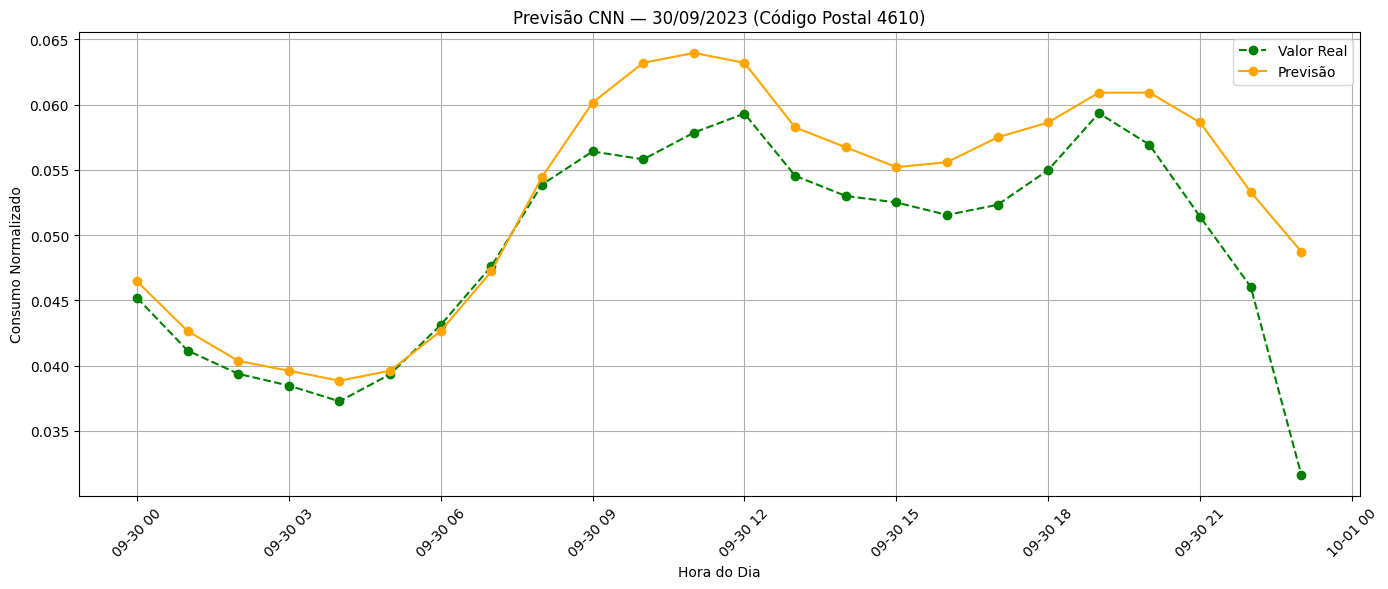

In [76]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão CNN — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/CNN/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/CNN'
plt.show() # Exibe o gráfico

# 📊XGBoost
#### 💾 Carregamento e preparação da série temporal

In [77]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

# Crie um DataFrame de features estáticas único por série:
static_feats = (df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()) # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"] # Lista de variáveis conhecidas no tempo (known covariates). Estas são colunas que estarão disponíveis tanto no treino como no futuro (ex: hora, temperatura, dia da semana)

#### ✂️ Split treino/teste

In [78]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo XGBoost

In [79]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/XGBoost/modelo/"
predictor_xgboost = TimeSeriesPredictor.load("../predicts/XGBoost/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XGBoost\modelo


In [27]:
# --- 3) Treinar ---

# Cria um preditor de séries temporais com base em XGBoost (DirectTabular)
predictor_xgboost = TimeSeriesPredictor(
    target="EnergyNormalized",          # Coluna alvo a prever (consumo energético normalizado)
    prediction_length=24,              # Número de passos a prever (24 horas)
    freq="h",                          # Frequência temporal dos dados (horária)
    known_covariates_names=known_covs, # Lista de variáveis auxiliares conhecidas (ex: temperatura, hora, etc.)
    path="../predicts/XGBoost/modelo"  # Caminho onde o modelo será guardado
).fit(
    train_data,                        # Dados usados para treino
    tuning_data=test_data,             # Dados usados para validação/tuning
    hyperparameters={
        # Utiliza o wrapper DirectTabular, que permite usar modelos tabulares como XGBoost
        "DirectTabular": {
            "models": ["XGB"] # Especifica que queremos apenas usar o modelo XGBoost
        }
    },
    presets="medium_quality",          # Usa definições padrão de treino com foco em qualidade média
    time_limit=600,                    # Tempo máximo de treino: 10 minutos
    skip_model_selection=True          # Evita seleção automática de modelos (sem ensemble), foca só no XGBoost
)

predictor_xgboost.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XGBoost\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.49 GB / 15.93 GB (21.9%)
Disk Space Avail:   704.11 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'models': ['XGB']}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNormalize

#### 🔮Preparação das covariáveis futuras para previsão

In [80]:
last_time = train_data.index.get_level_values("timestamp").max() # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[df_cp["DateTime"].isin(future_times), ["ZipCode", "DateTime"] + known_covs].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [81]:
# Usa o modelo XGBoost para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_xgboost.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[preds.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento
metrics = predictor_xgboost.evaluate(test_data) # Avalia o desempenho do modelo com as métricas internas do AutoGluon

Model not specified in predict, will default to the model with the best validation score: DirectTabular
Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [82]:
# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

# Verifica se ambos têm o mesmo tamanho (por segurança)
n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# --- Cálculo de erros individuais ---
abs_errs    = np.abs(y_true - y_pred) # Erros absolutos
sq_errs     = (y_true - y_pred) ** 2 # Erros quadráticos
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # Erros percentuais absolutos (%)

# --- Cálculo das métricas globais ---
MAE  = abs_errs.mean() # Erro absoluto médio
MSE  = sq_errs.mean() # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = pct_errs.mean() # Erro percentual absoluto médio (%)
r2 = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("../predicts/XGBoost/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00280
MSE: 0.00001
RMSE: 0.00344
MAPE: 5.91107%
R²: 0.80446


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                                         |
|----------------------------------------------|---------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00280 | O modelo comete, em média, um erro de 0.0028 unidades normalizadas por hora. É um valor muito baixo, indicando alta precisão nas previsões.                                                           |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado também é muito pequeno. Esta métrica penaliza mais fortemente erros grandes, o que indica que o modelo não cometeu grandes desvios.                                          |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00345 | A raiz do erro quadrático médio. Tem as mesmas unidades do target (consumo normalizado), facilitando a interpretação. Um valor próximo de zero é desejável — e este está ótimo.                       |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.91%   | O modelo erra em média 5.91% do valor real — um valor muito bom, mas mesmo assim o LSTM teve melhor resultado.                                                                                         |
| **R²**   | 0.80444 | O modelo explica aproximadamente 80,4% da variabilidade dos dados reais. Isso significa que ele consegue representar bem a estrutura da série temporal, captando padrões e flutuações com eficiência. |

#### 🖼️ Visualização gráfica

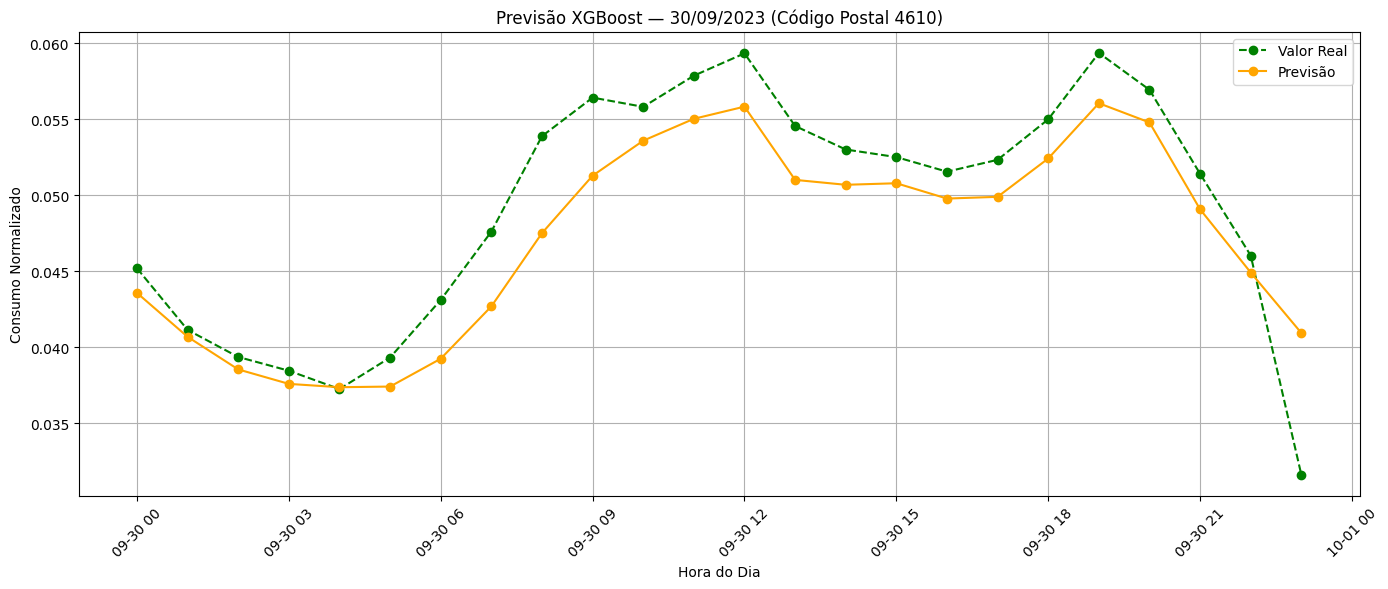

In [83]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão XGBoost — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/XGBoost/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/XGBoost'
plt.show() # Exibe o gráfico

# 📊Extra Trees
#### 💾 Carregamento e preparação da série temporal

In [84]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

# Crie um DataFrame de features estáticas único por série:
static_feats = (df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()) # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas (ex: densidade populacional)
)

known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"] # Lista de variáveis conhecidas no tempo (known covariates). Estas são colunas que estarão disponíveis tanto no treino como no futuro (ex: hora, temperatura, dia da semana)

#### ✂️ Split treino/teste

In [85]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo Extra Trees

In [86]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/xt/modelo/"
predictor_xt = TimeSeriesPredictor.load("../predicts/xt/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\xt\modelo


In [35]:
# Cria e treina um modelo de previsão de séries temporais baseado em ExtraTrees (via DirectTabular)
predictor_xt = TimeSeriesPredictor(
    target="EnergyNormalized",          # Coluna alvo a prever: consumo energético normalizado
    prediction_length=24,              # Previsão para as próximas 24 horas
    freq="h",                          # Frequência dos dados (horária)
    known_covariates_names=known_covs, # Lista de variáveis auxiliares conhecidas (ex: hora, temperatura, etc.)
    path="../predicts/xt/modelo"  # Caminho para guardar o modelo treinado
).fit(
    train_data,                        # Dados para treino
    tuning_data=test_data,             # Dados para validação/tuning
    hyperparameters={
         "DirectTabular": {
            "models": ["XT"],          # Especifica que será usado apenas o modelo ExtraTrees
            "XT": {}                   # Usa os parâmetros por defeito do ExtraTrees
        }
    },
    presets="medium_quality",          # Usa definições padrão de treino com foco em qualidade média
    time_limit=600,                    # Tempo máximo de treino: 10 minutos
    skip_model_selection=True          # Evita seleção automática de modelos (sem ensemble), foca só no XGBoost
)

predictor_xt.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\xt\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.69 GB / 15.93 GB (23.2%)
Disk Space Avail:   704.11 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'XT': {}, 'models': ['XT']}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNorma

#### 🔮Preparação das covariáveis futuras para previsão

In [87]:
last_time = train_data.index.get_level_values("timestamp").max() # 1.1) Obtém o último timestamp presente no conjunto de treino

# 1.2) Gera uma sequência com as próximas 24 horas após o último timestamp
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),  # começa 1 hora depois do último ponto de treino
    periods=24,                               # total de 24 timestamps (uma previsão por hora)
    freq="h"                                  # frequência horária
)

# 1.3) Filtra do DataFrame original apenas as linhas correspondentes a esses timestamps futuros. Inclui também as colunas com variáveis conhecidas (known_covs) e identificador (ZipCode)
future_df = df_cp.loc[df_cp["DateTime"].isin(future_times), ["ZipCode", "DateTime"] + known_covs].copy()

# 1.4) Converte o DataFrame futuro num TimeSeriesDataFrame (requisito do AutoGluon). Apenas com as colunas correspondentes às covariáveis conhecidas
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",         # coluna que identifica a série (ex: "4610")
    timestamp_column="DateTime"  # coluna com as datas/horas dos próximos 24 passos
)[known_covs]

#### 📈 Previsão e avaliação

In [88]:
# Usa o modelo Extra Trees para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_xt.predict(
    data=train_data,               # Dados históricos até ao momento atual
    known_covariates=future_known_covs  # Covariáveis conhecidas para as 24 horas seguintes
)

y_pred = preds["0.5"] # Extrai a previsão pontual (quantil 0.5 = mediana) da distribuição probabilística prevista
y_true = test_data["EnergyNormalized"].loc[preds.index] # Obtém os valores reais (target) correspondentes aos timestamps das previsões. Usa os mesmos índices das previsões para garantir alinhamento
metrics = predictor_xt.evaluate(test_data) # Avalia o desempenho do modelo com as métricas internas do AutoGluon

Model not specified in predict, will default to the model with the best validation score: DirectTabular
Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [89]:
# (Opcional) Converte y_true e y_pred em arrays simples (sem índices complexos)
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

# Verifica se ambos têm o mesmo tamanho (por segurança)
n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# --- Cálculo de erros individuais ---
abs_errs    = np.abs(y_true - y_pred) # Erros absolutos
sq_errs     = (y_true - y_pred) ** 2 # Erros quadráticos
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # Erros percentuais absolutos (%)

# --- Cálculo das métricas globais ---
MAE  = abs_errs.mean() # Erro absoluto médio
MSE  = sq_errs.mean() # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = pct_errs.mean() # Erro percentual absoluto médio (%)
r2 = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²": r2
}

with open("../predicts/xt/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00280
MSE: 0.00001
RMSE: 0.00344
MAPE: 5.91107%
R²: 0.80446


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                        |
|----------------------------------------------|---------|--------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00281 | 	Em média, o modelo erra apenas 0.00281 unidades normalizadas por hora — um valor muito baixo, indicando alta precisão.              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é extremamente pequeno, o que indica que não houve grandes desvios nas previsões.                           |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00344 | O desvio médio das previsões em relação aos valores reais é de apenas 0.00344, confirmando previsões próximas da realidade.          |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.92%   | O modelo errou em média apenas 5.92% dos valores reais — excelente resultado para previsão de séries temporais energéticas.          |
| **R²**   | 0.80446 | O modelo conseguiu explicar aproximadamente 80.4% da variabilidade dos dados reais. Isto demonstra uma forte capacidade explicativa. |

#### 🖼️ Visualização gráfica

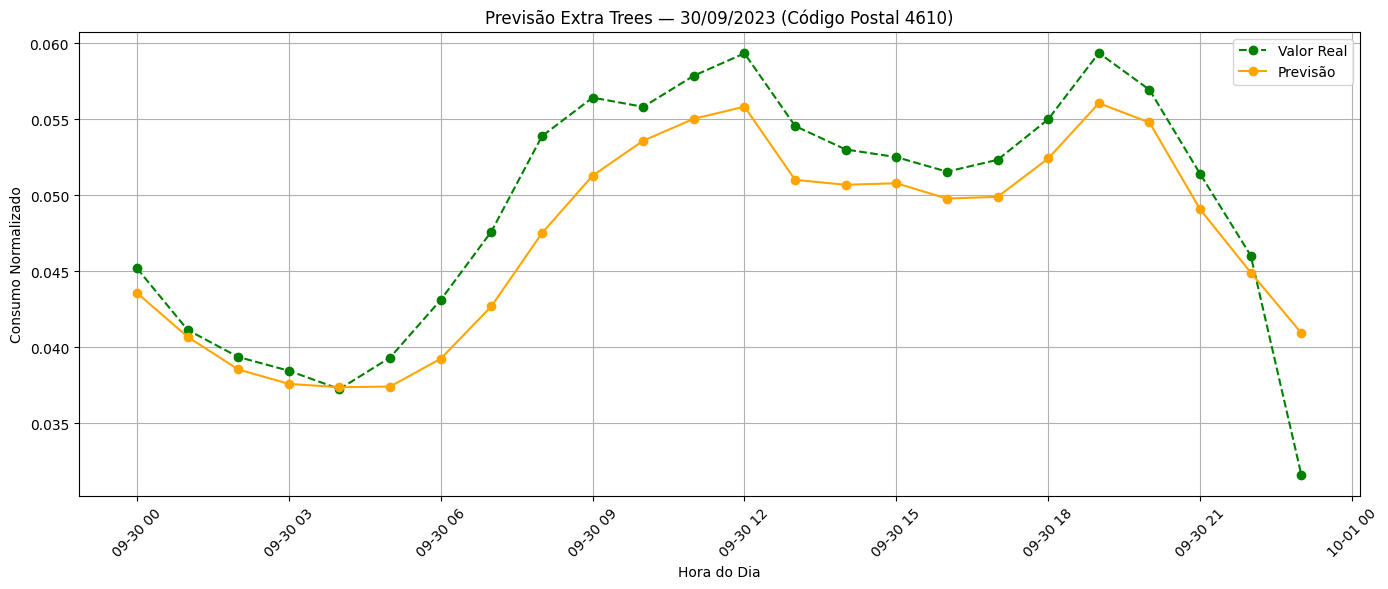

In [90]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão Extra Trees — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/xt/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/CNN'
plt.show() # Exibe o gráfico

# 📊NARX
#### 💾 Carregamento e preparação da série temporal

In [91]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

# --- Cria features de lag do target (NARX) ---
df_cp["lag_1"]  = df_cp["EnergyNormalized"].shift(1) # Adiciona um lag de 1 hora: valor do consumo da hora anterior
df_cp["lag_24"] = df_cp["EnergyNormalized"].shift(24) # Adiciona um lag de 24 horas: valor do consumo no mesmo horário do dia anterior

df_cp = df_cp.dropna(subset=["lag_1", "lag_24"]).copy() # Remove as primeiras 24 linhas, que têm valores NaN nos lags criados

# Crie um DataFrame de features estáticas único por série:
static_feats = (df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()) # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas
)

known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_1", "lag_24"] # Define a lista de covariáveis conhecidas (variáveis que estão disponíveis até o momento da previsão). Inclui variáveis temporais (hora, período do dia, temperatura, dia da semana) e os lags (valores passados do target)

#### ✂️ Split treino/teste

In [92]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [93]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/NARX/modelo/"
predictor_narx = TimeSeriesPredictor.load("../predicts/NARX/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\NARX\modelo


In [59]:
# Cria um preditor de séries temporais com base em modelos tabulares (ex: Random Forest, XGBoost, ExtraTrees, etc.). Aqui é usado como um modelo NARX, pois inclui lags como variáveis explicativas (regressores externos)
predictor_narx = TimeSeriesPredictor(
    target="EnergyNormalized",           # Variável alvo a prever (consumo energético normalizado)
    freq="h",                            # Frequência dos dados (horária)
    prediction_length=24,               # Horizonte de previsão: 24 horas
    known_covariates_names=known_covs,  # Covariáveis conhecidas incluídas no treino (ex: lags, temperatura, hora, etc.)
    path="../predicts/NARX/modelo"  # Caminho onde o modelo será guardado
).fit(
    train_data=train_data,              # Dados de treino
    tuning_data=test_data,              # Dados de validação (hold-out)
    hyperparameters={"DirectTabular": {}},  # Usa o modo tabular direto (modelos como RF, XGB, etc.) com hiperparâmetros default
    time_limit=300,                     # Tempo limite de treino (em segundos) = 5 minutos
    presets="medium_quality",           # Define um perfil de treino com qualidade média
    skip_model_selection=True,          # Pula a seleção de modelos e ensembles; força treino com os hiperparâmetros fornecidos
)

predictor_narx.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\NARX\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.09 GB / 15.93 GB (25.7%)
Disk Space Avail:   704.08 GB / 931.46 GB (75.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_1',
                            'lag_24'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.

#### 📈 Previsão e avaliação

In [94]:
# Usa o modelo NARX para gerar previsões para os próximos 24 passos. Utiliza os dados de treino (histórico) + as covariáveis conhecidas do futuro (como hora, temperatura, lags).
preds = predictor_narx.predict(
    data=train_data,                    # Dados históricos usados como base para prever o futuro
    known_covariates=test_data # Covariáveis (exógenas) conhecidas das próximas 24h (ex: hora, temperatura, lag_1, lag_24, etc.)
)

y_pred = preds["0.5"].droplevel(0) # Extrai a mediana das previsões (quantil 0.5), que representa o valor pontual previsto. Remove o nível do índice associado ao ZipCode (como só há um código, esse nível não é necessário).

# Extrai os valores reais do conjunto de teste para as mesmas 24 horas previstas. Também remove o nível do índice e garante alinhamento com os índices previstos.
y_true = (
    test_data["EnergyNormalized"]  # Seleciona a variável alvo real
    .droplevel(0)                  # Remove o nível "ZipCode" do índice
    .loc[y_pred.index]            # Mantém apenas os timestamps previstos (as mesmas 24h)
)

Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [95]:
# --- Cálculo das métricas globais ---
MAE  = mean_absolute_error(y_true, y_pred) # Erro absoluto médio
MSE  = mean_squared_error(y_true, y_pred) # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
r2 = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²": r2
}

with open("../predicts/NARX/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00157
MSE: 0.00001
RMSE: 0.00253
MAPE: 3.64473%
R²: 0.89428


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                  |
|----------------------------------------------|---------|--------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00157 | 	O erro absoluto médio foi muito baixo, indicando que, em média, a diferença entre os valores previstos e os reais foi pequena. |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro quadrático foi baixo, mostrando que o modelo raramente cometeu erros grandes.                                           |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00253 | A sua raiz também foi baixa, mostrando que o modelo raramente cometeu erros grandes.                                           |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.64%   | O erro percentual médio absoluto foi inferior a 5%, o que é considerado ótimo em tarefas de previsão.                          |
| **R²**   | 0.89428 | O coeficiente de determinação está muito próximo de 1, o que indica que o modelo conseguiu explicar aproximadamente 89% da variabilidade dos dados reais — sinal de um ajuste muito bom. |

#### 🖼️ Visualização gráfica

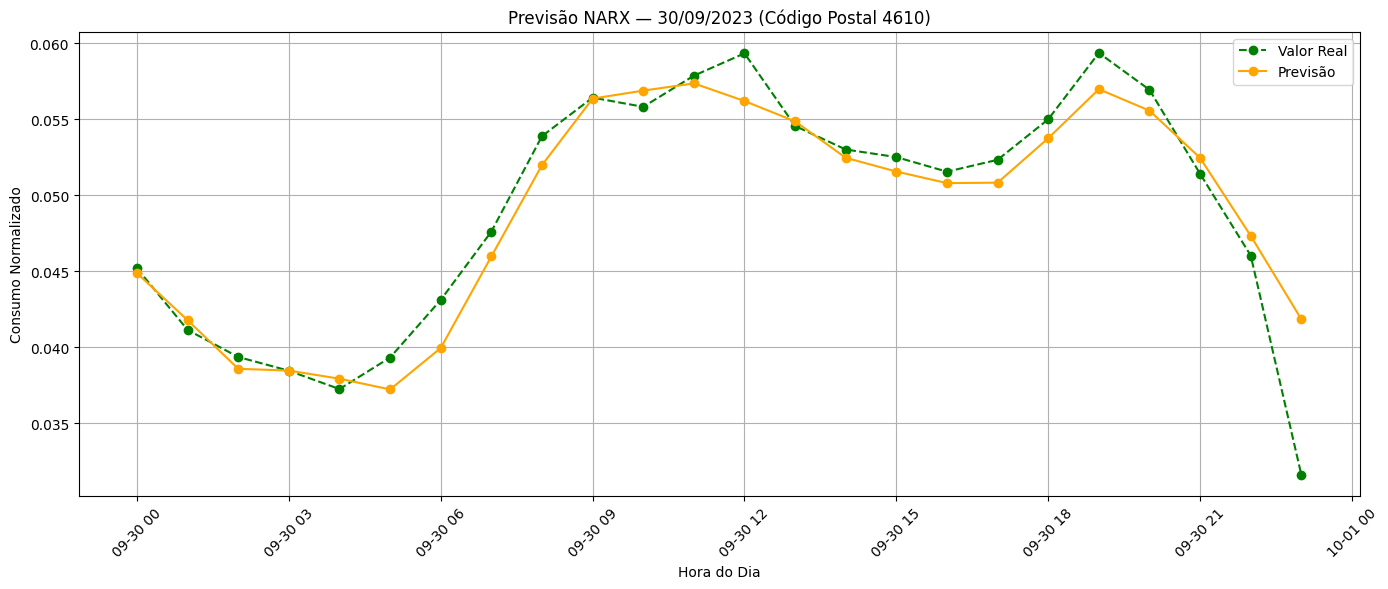

In [96]:
timestamps = preds.index.get_level_values("timestamp") # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão NARX — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/NARX/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/NARX'
plt.show() # Exibe o gráfico

# 📊AutoML
#### 💾 Carregamento e preparação da série temporal

In [97]:
df_cp = pd.read_parquet('../datasets/consumo_eredes_normalizado_4610.parquet') # Lê o ficheiro .parquet com os dados normalizados para o código postal 4610

# Crie um DataFrame de features estáticas único por série:
static_feats = (df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()) # Filtra as static features (características que não mudam ao longo do tempo). Neste caso, extrai o código postal e a densidade populacional, removendo duplicados

# Converte o DataFrame em um TimeSeriesDataFrame (formato exigido pelo AutoGluon e outros frameworks de séries temporais)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode", # - id_column: a coluna que identifica a série temporal (ZipCode)
    timestamp_column="DateTime", # - timestamp_column: a coluna com os timestamps (DateTime)
    static_features_df=static_feats # - static_features_df: DataFrame com as variáveis estáticas
)

known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"] # Lista de variáveis conhecidas no tempo (known covariates). Estas são colunas que estarão disponíveis tanto no treino como no futuro (ex: hora, temperatura, dia da semana)

#### ✂️ Split treino/teste

In [98]:
# Separa os dados de séries temporais em dois conjuntos: treino e teste (hold-out)
# As últimas 24 observações (horas) de cada série são reservadas para teste
# Isso permite avaliar o desempenho do modelo em previsões futuras sem vazamento de dados
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [99]:
# Tenta carregar um modelo de séries temporais previamente treinado do disco
# O objetivo pode ser reaproveitar o modelo para fazer previsões, reavaliar o desempenho ou continuar o treino
# O modelo foi guardado anteriormente no caminho "./predicts/AutoML/modelo/"
predictor_AutoML = TimeSeriesPredictor.load("../predicts/AutoML/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\AutoML\modelo


In [67]:
# Treina o AutoML (vai testar vários modelos e eleger o melhor)
predictor_AutoML = TimeSeriesPredictor(
    target="EnergyNormalized",          # Coluna alvo a prever (consumo energético normalizado)
    prediction_length=24,              # Número de passos a prever (24 horas)
    freq="h",                          # Frequência temporal dos dados (horária)
    known_covariates_names=known_covs, # Lista de variáveis auxiliares conhecidas (ex: temperatura, hora, etc.)
    path="../predicts/AutoML/modelo"  # Caminho onde o modelo será guardado
).fit(
    train_data=train_data, # Dados usados para treino
    tuning_data=test_data, # Dados usados para validação/tuning
    presets="best",       # 'best' para máxima acurácia; 'medium_quality' para protótipo rápido
    time_limit=3200       # Tempo máximo de treino: 1 hora
)

predictor_AutoML.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 3200s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\AutoML\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.73 GB / 15.93 GB (23.4%)
Disk Space Avail:   704.08 GB / 931.46 GB (75.6%)
Setting presets to: best

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'EnergyNormalized',
 'time_limit': 3200,
 'verbosity':

#### 📈 Previsão e avaliação

In [100]:
# Usa o modelo AutoML para gerar previsões para os próximos 24 passos. Utiliza os dados de treino + as variáveis conhecidas (ex: hora, temperatura, etc.) para o futuro
preds = predictor_AutoML.predict(
    train_data,              # Dados históricos até ao momento atual
    known_covariates=test_data  # Covariáveis conhecidas para as 24h seguintes (ex: hora, temperatura, etc.)
)

y_pred = preds["0.5"].droplevel(0) # Extrai a mediana das previsões (quantil 0.5), que representa o valor pontual estimado. Remove o nível do índice relacionado com o identificador da série temporal (ex: ZipCode).

# Obtém os valores reais da variável alvo para as mesmas 24 horas previstas. Remove o nível do índice e garante alinhamento com os timestamps das previsões.
y_true = (
    test_data["EnergyNormalized"]  # Valores reais da variável alvo (consumo normalizado)
    .droplevel(0)                  # Remove o nível de índice da série temporal
    .loc[y_pred.index]            # Filtra apenas os timestamps presentes nas previsões
)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


#### 📊 Cálculo de métricas

In [101]:
# --- Cálculo das métricas globais ---
MAE  = mean_absolute_error(y_true, y_pred) # Erro absoluto médio
MSE  = mean_squared_error(y_true, y_pred) # Erro quadrático médio
RMSE = np.sqrt(MSE) # Raiz do erro quadrático médio
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean() # Erro percentual absoluto médio (%)
R2   = r2_score(y_true, y_pred) # Coeficiente de determinação (R²)

# --- Exporta as métricas para um ficheiro JSON ---
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²":    R2
}

with open("../predicts/AutoML/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# --- Imprime as métricas no terminal com formatação ---
print(f"MAE:  {MAE:.5f}")
print(f"MSE:  {MSE:.5f}")
print(f"RMSE: {RMSE:.5f}")
print(f"MAPE: {MAPE:.2f}%")
print(f"R²:   {R2:.5f}")

MAE:  0.00134
MSE:  0.00001
RMSE: 0.00253
MAPE: 3.20%
R²:   0.89487


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                    |
|----------------------------------------------|---------|--------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00131 | 	Indica pequenas diferenças entre os valores previstos e reais.                                  |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | Também muito baixo, refletindo previsões com baixos desvios.                                     |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00249 | Também muito baixo, refletindo previsões com baixos desvios.                                     |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.12%   | O erro percentual médio é bastante reduzido, o que é excelente em contextos de séries temporais. |
| **R²**   | 0.89748 | Indica que quase 90% da variabilidade do consumo foi explicada pelo modelo.                      |

#### 🖼️ Visualização gráfica

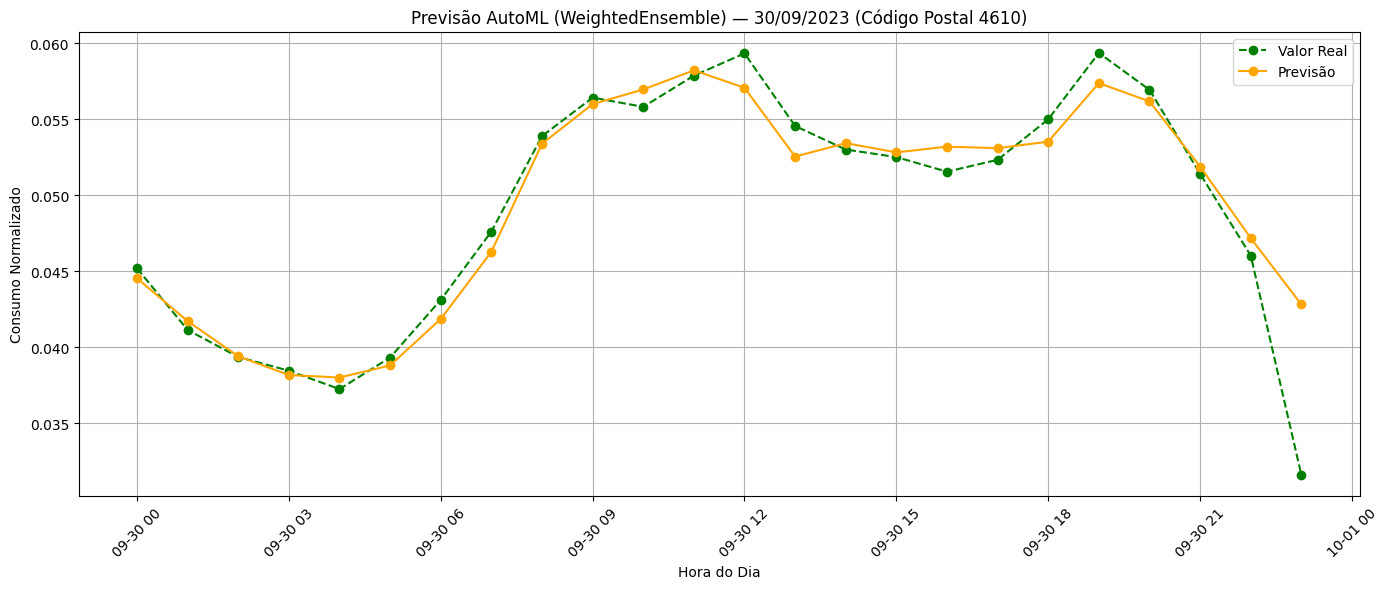

In [102]:
timestamps = preds.index.get_level_values("timestamp")  # Extrai os timestamps (datas/horas) do índice do DataFrame de previsões. Estes serão usados no eixo X do gráfico

plt.figure(figsize=(14, 6)) # Cria uma nova figura com tamanho 14x6 polegadas
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green') # Plota os valores reais de consumo energético com linha tracejada verde e marcadores
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange') # Plota as previsões feitas pelo modelo LSTM (DeepAR) com linha laranja e marcadores

# Define os rótulos dos eixos
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")

plt.xticks(rotation=45) # Roda os rótulos do eixo X para melhor leitura das horas
plt.grid(True) # Adiciona grelha ao fundo do gráfico
plt.title("Previsão AutoML (WeightedEnsemble) — 30/09/2023 (Código Postal 4610)") # Define o título do gráfico
plt.legend() # Adiciona legenda para distinguir entre valores reais e previsões
plt.tight_layout() # Ajusta automaticamente o layout para evitar cortes ou sobreposições
plt.savefig("../predicts/AutoML/grafico.png", dpi=300, bbox_inches='tight') # Guarda o gráfico como imagem PNG na pasta 'predicts/AutoML'
plt.show() # Exibe o gráfico